In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(511, 15) (146, 15) (47, 15)


In [6]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD
0,0.315963,0.310705,0.317946,0.319157,0.319157,0.064434,0.306098,0.332838,0.316790,0.327075,0.452657,0.668763,0.353842,0.359191,0.345692
1,0.319190,0.329837,0.324101,0.343654,0.343654,0.092630,0.312375,0.332512,0.326433,0.331283,0.476904,0.794436,0.350655,0.360462,0.366879
2,0.344066,0.347136,0.351019,0.357384,0.357384,0.084282,0.320394,0.333672,0.337342,0.336945,0.540000,1.000000,0.346514,0.363040,0.391496
3,0.357522,0.363782,0.360018,0.377811,0.377811,0.076679,0.330721,0.335341,0.350996,0.344850,0.559219,1.000000,0.352486,0.359697,0.422232
4,0.378650,0.461519,0.387694,0.416192,0.416192,0.360494,0.349668,0.341625,0.371518,0.357337,0.728010,1.000000,0.367451,0.349285,0.467356


## `DataWindow` class 

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [10]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [11]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [12]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.0608 - mean_absolute_error: 0.1345


### Repeat last day 

In [13]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [14]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1387


## Linear model 

In [15]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 1s 17ms/step - loss: 0.1784 - mean_absolute_error: 0.3398 - val_loss: 0.0134 - val_mean_absolute_error: 0.0997
Epoch 2/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0961 - mean_absolute_error: 0.2419 - val_loss: 0.0044 - val_mean_absolute_error: 0.0522
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0483 - mean_absolute_error: 0.1735 - val_loss: 0.0026 - val_mean_absolute_error: 0.0453
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0243 - mean_absolute_error: 0.1267 - val_loss: 0.0043 - val_mean_absolute_error: 0.0577
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.1001 - val_loss: 0.0064 - val_mean_absolute_error: 0.0701
Epoch 6/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0763


## Dense model 

In [16]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 1s 19ms/step - loss: 0.1637 - mean_absolute_error: 0.3205 - val_loss: 0.0044 - val_mean_absolute_error: 0.0566
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0293 - mean_absolute_error: 0.1420 - val_loss: 0.0267 - val_mean_absolute_error: 0.1550
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0123 - mean_absolute_error: 0.0932 - val_loss: 0.0040 - val_mean_absolute_error: 0.0553
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0698 - val_loss: 0.0019 - val_mean_absolute_error: 0.0372
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0484 - val_loss: 0.0015 - val_mean_absolute_error: 0.0281
Epoch 7/1000
16

## LSTM model 

In [17]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 3s 44ms/step - loss: 0.1894 - mean_absolute_error: 0.3499 - val_loss: 0.0128 - val_mean_absolute_error: 0.0956
Epoch 2/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0754 - mean_absolute_error: 0.2049 - val_loss: 0.0272 - val_mean_absolute_error: 0.1343
Epoch 3/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0454 - mean_absolute_error: 0.1700 - val_loss: 0.0101 - val_mean_absolute_error: 0.0832
Epoch 4/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0321 - mean_absolute_error: 0.1299 - val_loss: 0.0046 - val_mean_absolute_error: 0.0561
Epoch 5/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0243 - mean_absolute_error: 0.1132 - val_loss: 0.0033 - val_mean_absolute_error: 0.0473
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0182 - mean_absolute_error: 0.0948 - val_loss: 0.0023 - val_mean_absolute_error: 0.0388
Epoch 7/100

## CNN model 

In [18]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [19]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 1s 22ms/step - loss: 0.1878 - mean_absolute_error: 0.3476 - val_loss: 0.0093 - val_mean_absolute_error: 0.0797
Epoch 2/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0442 - mean_absolute_error: 0.1594 - val_loss: 0.0299 - val_mean_absolute_error: 0.1616
Epoch 3/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0160 - mean_absolute_error: 0.1070 - val_loss: 0.0047 - val_mean_absolute_error: 0.0597
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0798 - val_loss: 0.0038 - val_mean_absolute_error: 0.0528
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_error: 0.0594 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0532 - val_loss: 0.0020 - val_mean_absolute_error: 0.0341
Epoch 7/1000
16

## CNN + LSTM model 

In [20]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 5s 45ms/step - loss: 0.1859 - mean_absolute_error: 0.3448 - val_loss: 0.0088 - val_mean_absolute_error: 0.0754
Epoch 2/1000
16/16 [==============================] - 0s 14ms/step - loss: 0.0616 - mean_absolute_error: 0.1928 - val_loss: 0.0535 - val_mean_absolute_error: 0.1984
Epoch 3/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0363 - mean_absolute_error: 0.1522 - val_loss: 0.0061 - val_mean_absolute_error: 0.0662
Epoch 4/1000
16/16 [==============================] - 0s 14ms/step - loss: 0.0199 - mean_absolute_error: 0.1039 - val_loss: 0.0043 - val_mean_absolute_error: 0.0545
Epoch 5/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0123 - mean_absolute_error: 0.0792 - val_loss: 0.0036 - val_mean_absolute_error: 0.0500
Epoch 6/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0094 - mean_absolute_error: 0.0708 - val_loss: 0.0030 - val_mean_absolute_error: 0.0439
Epoch 7/10

## Autoregressive LSTM 

In [21]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [22]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 4s 38ms/step - loss: 0.1722 - mean_absolute_error: 0.3232 - val_loss: 0.0223 - val_mean_absolute_error: 0.1144
Epoch 2/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0677 - mean_absolute_error: 0.1926 - val_loss: 0.0099 - val_mean_absolute_error: 0.0788
Epoch 3/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0181 - mean_absolute_error: 0.1010 - val_loss: 0.0058 - val_mean_absolute_error: 0.0601
Epoch 4/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0083 - mean_absolute_error: 0.0709 - val_loss: 0.0042 - val_mean_absolute_error: 0.0516
Epoch 5/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_absolute_error: 0.0595 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 6/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0031 - val_mean_absolute_error: 0.0449
Epoch 7/10

In [23]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 4s 51ms/step - loss: 0.1914 - mean_absolute_error: 0.3508 - val_loss: 0.0104 - val_mean_absolute_error: 0.0829
Epoch 2/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0692 - mean_absolute_error: 0.2017 - val_loss: 0.0525 - val_mean_absolute_error: 0.1926
Epoch 3/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0407 - mean_absolute_error: 0.1601 - val_loss: 0.0057 - val_mean_absolute_error: 0.0622
Epoch 4/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0243 - mean_absolute_error: 0.1094 - val_loss: 0.0043 - val_mean_absolute_error: 0.0537
Epoch 5/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0157 - mean_absolute_error: 0.0883 - val_loss: 0.0035 - val_mean_absolute_error: 0.0467
Epoch 6/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0105 - mean_absolute_error: 0.0731 - val_loss: 0.0028 - val_mean_absolute_error: 0.0420
Epoch 7/10

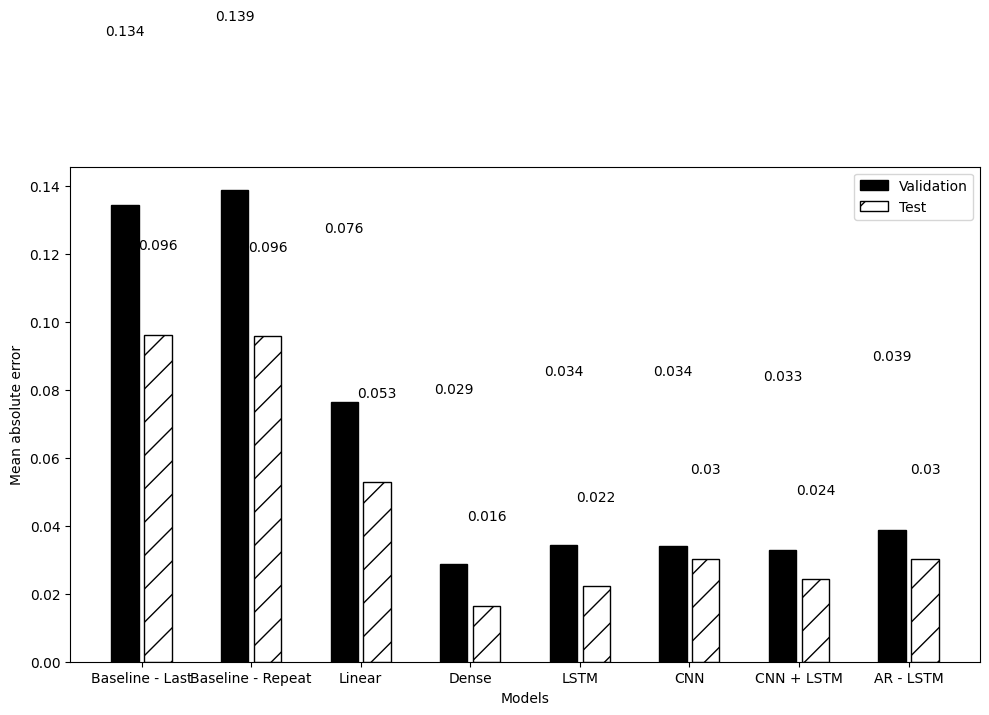

In [24]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.025, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/F14_peixeiro.png', dpi=300)